In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

df_p = pd.read_csv("car_price_prediction.csv")

df_p.head()


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [254]:
print(df_p.columns.tolist())
columns = df_p.columns.tolist()

['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags']


In [255]:
df_t = df_p
df_t.head()


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [256]:
print("Jumlah baris, kolom:", df_t.shape)    
print("\nTipe data:")
print(df_t)

df_t.describe()

Jumlah baris, kolom: (19237, 18)

Tipe data:
             ID  Price  Levy   Manufacturer    Model  Prod. year   Category  \
0      45654403  13328  1399          LEXUS   RX 450        2010       Jeep   
1      44731507  16621  1018      CHEVROLET  Equinox        2011       Jeep   
2      45774419   8467     -          HONDA      FIT        2006  Hatchback   
3      45769185   3607   862           FORD   Escape        2011       Jeep   
4      45809263  11726   446          HONDA      FIT        2014  Hatchback   
...         ...    ...   ...            ...      ...         ...        ...   
19232  45798355   8467     -  MERCEDES-BENZ  CLK 200        1999      Coupe   
19233  45778856  15681   831        HYUNDAI   Sonata        2011      Sedan   
19234  45804997  26108   836        HYUNDAI   Tucson        2010       Jeep   
19235  45793526   5331  1288      CHEVROLET  Captiva        2007       Jeep   
19236  45813273    470   753        HYUNDAI   Sonata        2012      Sedan   

      

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [257]:
print("Jumlah nilai kosong per kolom:\n", df_t.isnull().sum())
print("Jumlah data duplikat:", df_t.duplicated().sum())

Jumlah nilai kosong per kolom:
 ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
Jumlah data duplikat: 313


In [258]:
df_t['Color'].unique()


array(['Silver', 'Black', 'White', 'Grey', 'Blue', 'Green', 'Red',
       'Sky blue', 'Orange', 'Yellow', 'Brown', 'Golden', 'Beige',
       'Carnelian red', 'Purple', 'Pink'], dtype=object)

## **Penangan Null dan Duplikat**

In [259]:
df_t['Doors'] = df_t['Doors'].fillna(df_t['Doors'].mode()[0])
df_t['Color'] = df_t['Color'].fillna('Unknown')

df_t = df_t.drop_duplicates()


In [260]:
print(df_t.isnull().sum())
print("Duplikat:", df_t.duplicated().sum())

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
Duplikat: 0


## **Data Outlier**

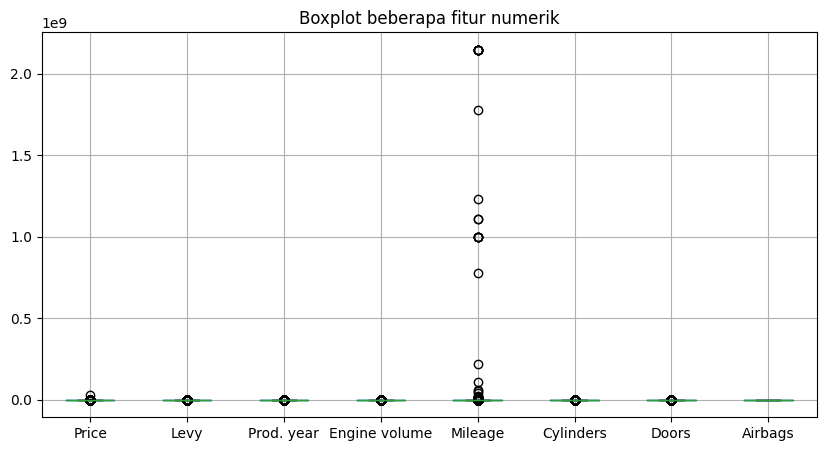

In [261]:
numeric_cols = [
    'Price', 'Levy', 'Prod. year', 'Engine volume',
    'Mileage', 'Cylinders', 'Doors', 'Airbags'
]
numeric_cols = [c for c in numeric_cols
                if c in df.columns]

plt.figure(figsize=(10, 5))
df[numeric_cols].boxplot()
plt.title("Boxplot beberapa fitur numerik")
plt.show()


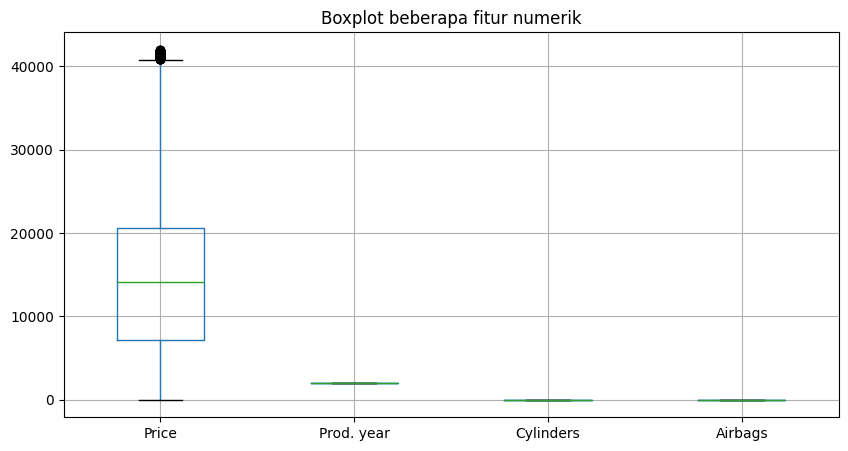

In [264]:
def handle_outlier_iqr(df, numeric_cols):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=np.number).columns

    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
            (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

    numeric_cols = [c for c in numeric_cols if c in df.columns]
    return df

df_t = handle_outlier_iqr(df_t, numeric_cols)


plt.figure(figsize=(10, 5))
df_t[numeric_cols].boxplot()
plt.title("Boxplot beberapa fitur numerik")
plt.show()

## **Encoding**

In [265]:
from sklearn.preprocessing import LabelEncoder

df_t = df_t.drop(columns=['ID'])

df_t['Levy'] = df_t['Levy'].replace('-', np.nan).astype(float)
df_t['Levy'] = df_t['Levy'].fillna(df_t['Levy'].median())

df_t['Mileage'] = df_t['Mileage'].str.replace(' km', '', regex=False).astype(int)

df_t['Engine volume'] = (
    df_t['Engine volume']
    .str.replace(' Turbo', '', regex=False)
    .astype(float)
)

df_t['Doors'] = df_t['Doors'].map({
    '02-Mar': 2,
    '04-May': 4
})

df_t["Doors"] = df_t["Doors"].fillna(df_t["Doors"].mode()[0])

df_t['Leather interior'] = df_t['Leather interior'].map({'Yes': 1, 'No': 0})

top_manufacturer = df_t['Manufacturer'].value_counts().nlargest(10).index
df_t['Manufacturer'] = df_t['Manufacturer'].where(
    df_t['Manufacturer'].isin(top_manufacturer),
    'Other'
)

top_model = df_t['Model'].value_counts().nlargest(20).index
df_t['Model'] = df_t['Model'].where(
    df_t['Model'].isin(top_model),
    'Other'
)

label_cols = [
    'Manufacturer', 'Model', 'Category',
    'Fuel type', 'Gear box type',
    'Drive wheels', 'Wheel'
]

le = LabelEncoder()
for col in label_cols:
    df_t[col] = le.fit_transform(df_t[col])

color_map = {
    'Black': 0,
    'White': 1,
    'Silver': 2,
    'Grey': 3,
    'Red': 4,
    'Blue': 5,
    'Green': 6,
    'Yellow': 7,
    'Sky blue': 8,
    'Orange': 9,
    'Brown': 10,
    'Golden': 11,
    'Beige': 12,
    'Carnelian red': 13,
    'Purple': 14,
    'Pink': 15
}

df_t['Color'] = df_t['Color'].map(color_map)





print(df_t.shape)
print(df_t.dtypes)
df_t.head()

(9267, 17)
Price                 int64
Levy                float64
Manufacturer          int32
Model                 int32
Prod. year            int64
Category              int32
Leather interior      int64
Fuel type             int32
Engine volume       float64
Mileage               int32
Cylinders           float64
Gear box type         int32
Drive wheels          int32
Doors               float64
Wheel                 int32
Color                 int64
Airbags               int64
dtype: object


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2,8467,751.0,2,8,2006,3,0,4,1.3,200000,4.0,3,1,4.0,1,0,2
3,3607,862.0,1,7,2011,4,1,2,2.5,168966,4.0,0,0,4.0,0,1,0
4,11726,446.0,2,8,2014,3,1,4,1.3,91901,4.0,0,1,4.0,0,2,4
5,39493,891.0,3,17,2016,4,1,1,2.0,160931,4.0,0,1,4.0,0,1,4
7,549,751.0,3,18,2013,8,1,4,2.4,216118,4.0,0,1,4.0,0,3,12


In [266]:
print("Jumlah nilai kosong per kolom:\n", df_t.isnull().sum())
print("Jumlah data duplikat:", df_t.duplicated().sum())

Jumlah nilai kosong per kolom:
 Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
Jumlah data duplikat: 1197


In [267]:
df_t = df_t.drop_duplicates()

print("Duplikat:", df_t.duplicated().sum())
print("Jumlah nilai kosong per kolom:\n", df_t.isnull().sum())
print("Jumlah data duplikat:", df_t.duplicated().sum())
df = df_t

Duplikat: 0
Jumlah nilai kosong per kolom:
 Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
Jumlah data duplikat: 0


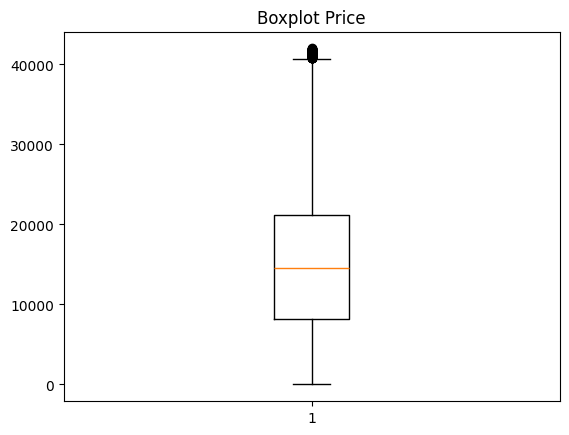

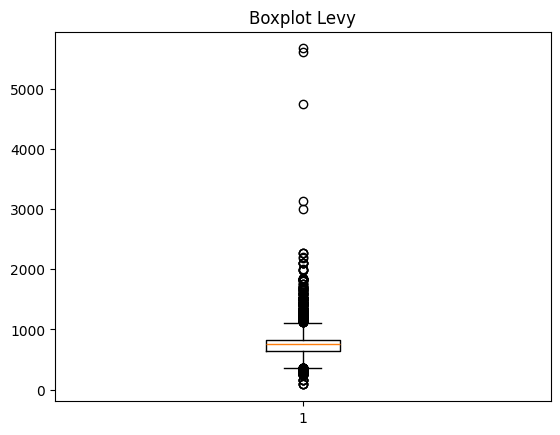

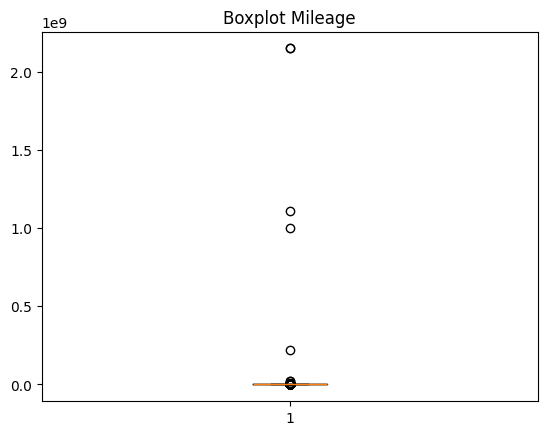

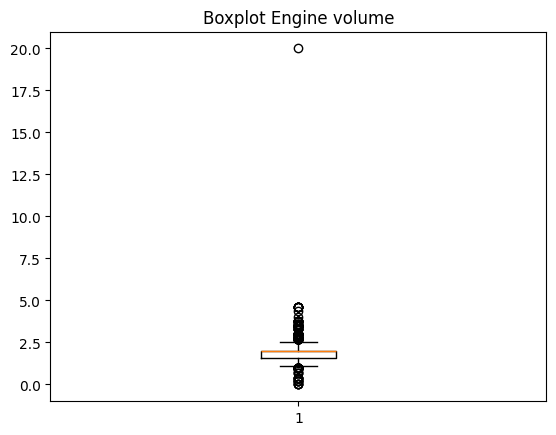

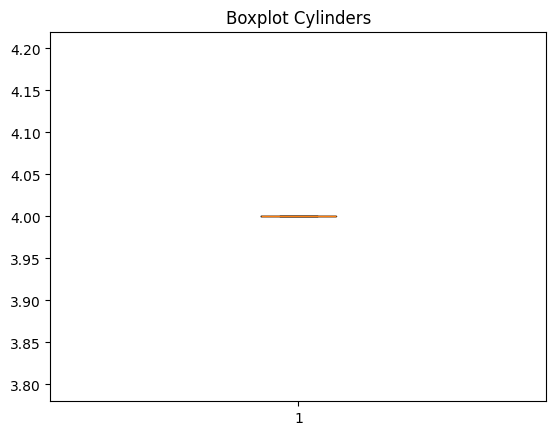

In [268]:
import matplotlib.pyplot as plt

num_cols = ['Price', 'Levy', 'Mileage', 'Engine volume', 'Cylinders']

for col in num_cols:
    plt.figure()
    plt.boxplot(df_t[col])
    plt.title(f'Boxplot {col}')
    plt.show()


In [271]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Price'])
y = df['Price']

rs = 86

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rs
)



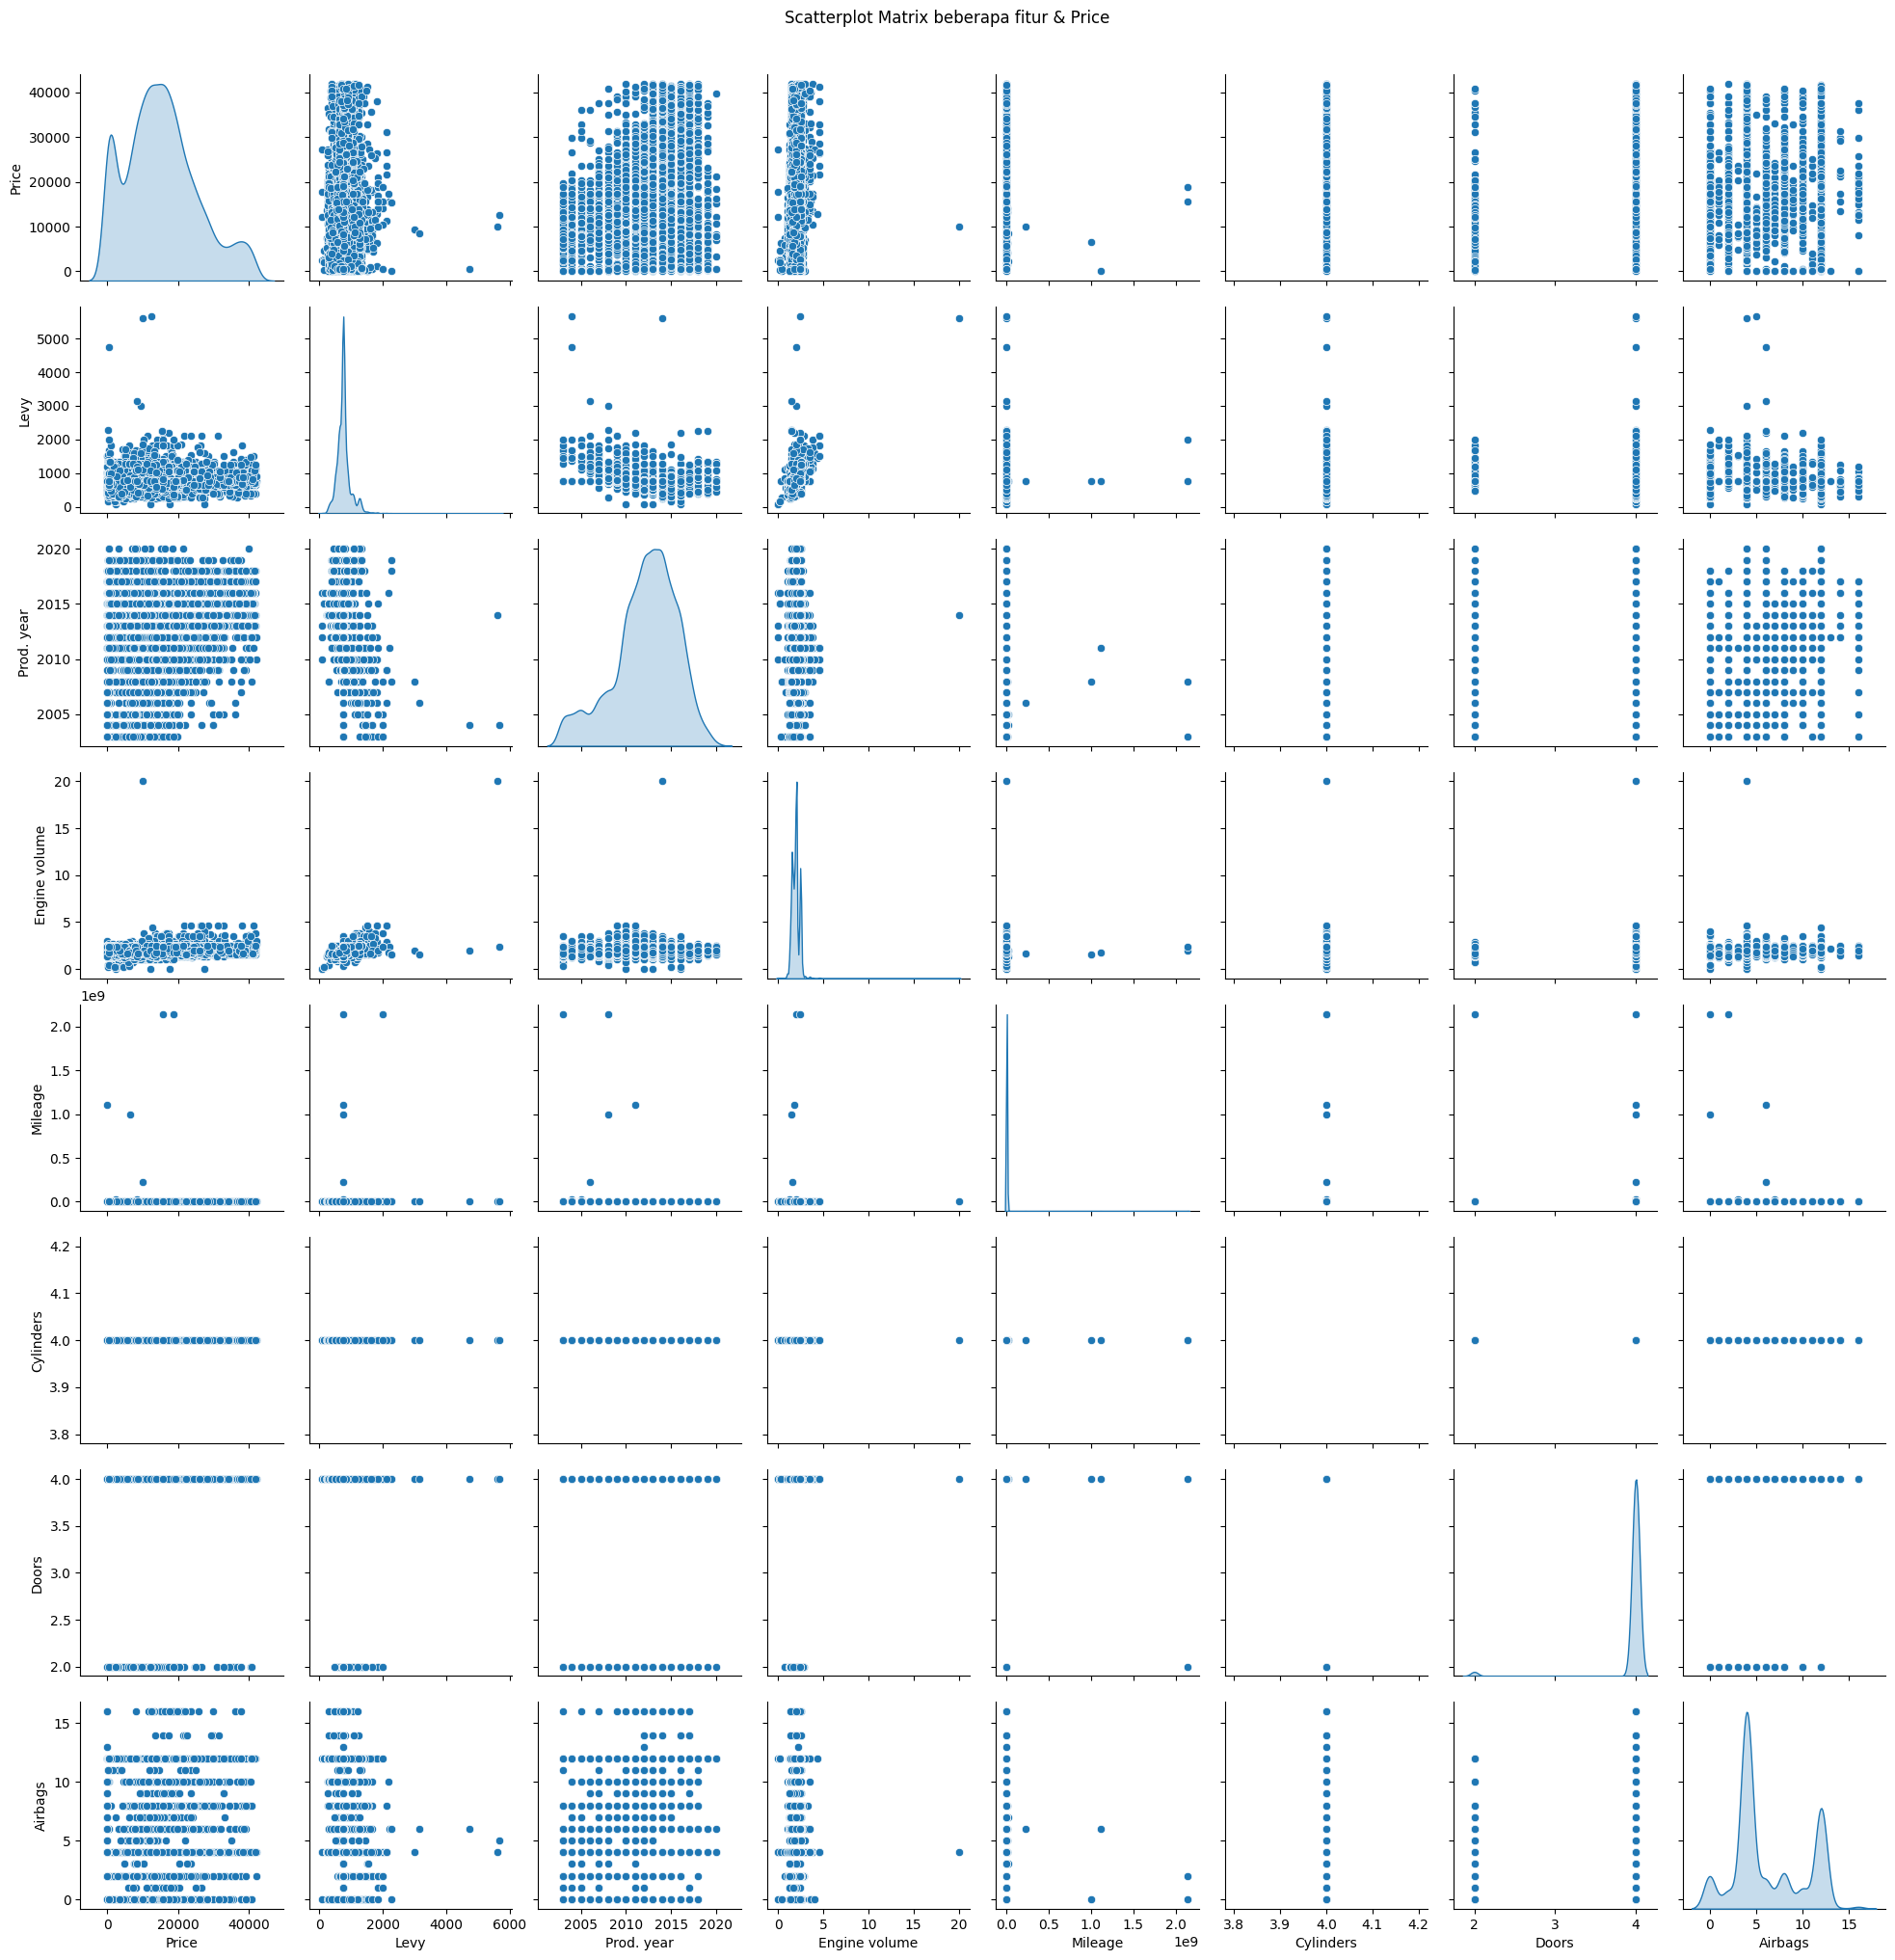

In [272]:
sns.pairplot(df[numeric_cols], diag_kind="kde")
plt.suptitle("Scatterplot Matrix beberapa fitur & Price", y=1.02)
plt.show()

## **Pipeline Lasso**

In [275]:

pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('model', Lasso(max_iter=10000))
])


param_grid_lasso = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'feature_selection': [
        SelectKBest(score_func=f_regression),
        SelectPercentile(score_func=f_regression)
    ],
    'feature_selection__k': [5, 10, 15],
    'feature_selection__percentile': [20, 40, 60],
    'model__alpha': [0.01, 0.1, 1, 10]
}


## **Pipeline Ridge**

In [ ]:
pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('model', Ridge())
])

param_grid_ridge = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'feature_selection': [
        SelectKBest(score_func=f_regression),
        SelectPercentile(score_func=f_regression)
    ],
    'feature_selection__k': [5, 10, 15],
    'feature_selection__percentile': [20, 40, 60],
    'model__alpha': [0.01, 0.1, 1, 10]
}

